# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [5]:
X.shape

(515345, 90)

Отмасштабируем данные (признаки и таргет)

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [7]:
model = Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [8]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

9.510160711373395

Теперь сделаем константный прогноз. Известно, что лучшее качество при константном прогнозе достигается при среднем значении.

In [14]:
def predict(y_train, y_test):
    return np.array([y_train.mean()] * len(y_test))

In [17]:
print("Train: ", mean_squared_error(y_train, predict(y_train, y_train), squared=False))
print("Test: ", mean_squared_error(y_test, predict(y_train, y_test), squared=False))

Train:  10.939755150678016
Test:  10.85246390513634


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [18]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [19]:
set_random_seed(6587)

Отмасштабируем наши данные. При том, как признаки, так и целевую переменную.

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler_x = MinMaxScaler(copy=False)
scaler_x.fit_transform(X_train)
scaler_x.transform(X_test)

Запомним `scale`, чтобы при подсчете лосса отмасштабировать таргет обратно.

In [22]:
scale_range = (y_train.max() - y_train.min())

In [23]:
scaler_y = MinMaxScaler(copy=False)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [24]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Я лично предпочту обучать на **CPU**, так как в силу небольших размеров тензоров, обучение будет проходить быстрее, чем на **GPU**.

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Создадим класс для нашей сети:

In [26]:
class SimpleModel(nn.Module):  
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(90, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.2)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(50, 25),
            nn.BatchNorm1d(25),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(25, 1)
        )

    def forward(self, x):

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x

Это тоже нормальная архитектура:)

In [146]:
# class SimpleModel(nn.Module):  
#     def __init__(self):
#         super().__init__()

#         self.fc1 = nn.Sequential(
#             nn.Linear(90, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(p=0.2)
#         )
#         self.fc2 = nn.Sequential(
#             nn.Linear(64, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#         )
#         self.fc3 = nn.Sequential(
#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Dropout(p=0.2)
#         )
#         self.fc4 = nn.Sequential(
#             nn.Linear(32, 1)
#         )

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        
#         return x

In [27]:
model = SimpleModel()
model.to(device)

SimpleModel(
  (fc1): Sequential(
    (0): Linear(in_features=90, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (fc3): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)

Перенесем данные в `DataLoader'ы`, а также определим оптимизатор и функцию ошибки:

In [28]:
train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_set, batch_size=128)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [31]:
from matplotlib import colors, pyplot as plt

Функция для отрисовки графиков лосса во время обучения.

In [32]:
def plot_loss(train_losses, val_losses, n_epochs):
    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="test")
    plt.legend(loc='best')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.xlim((0, n_epochs))
    plt.show()

In [33]:
from tqdm import tqdm
import sys
from IPython.display import clear_output

Функция для обучения и валидации:

In [35]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        # train
        model.train()
        batch_train_losses = []
        for ftrs, yrs in tqdm(train_dataloader, desc=f"Training, epoch {epoch}"):
            ftrs, yrs = ftrs.to(device), yrs.to(device)
            y_pred = model(ftrs)
            # print("pred:", y_pred, "init:", yrs)
            loss = criterion(y_pred, yrs)

            # RMSELoss_train = np.sqrt(loss.item()) * scale_range
            batch_train_losses.append(loss.cpu().detach().numpy())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        train_losses.append(np.sqrt(np.mean(batch_train_losses)) * scale_range)

        # validate
        batch_test_losses = []
        model.eval()
        with torch.no_grad():
            for ftrs, yrs in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}"):
                ftrs, yrs = ftrs.to(device), yrs.to(device)
                y_pred = model(ftrs)
                loss = criterion(y_pred, yrs)

                # RMSELoss_test = np.sqrt(loss.item()) * scale_range
                batch_test_losses.append(loss.cpu().numpy())

            val_losses.append(np.sqrt(np.mean(batch_test_losses)) * scale_range)

        clear_output()
        plot_loss(train_losses, val_losses, n_epochs)
        print("Train loss:", train_losses[-1])
        print("Val loss:", val_losses[-1])
    return train_losses, val_losses

In [41]:
def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = []
    losses = []
    loss = 0
    with torch.no_grad():
        for ftrs, yrs in tqdm(test_loader):
            y_pred = model(ftrs)
            predicts.append(y_pred)
            loss = criterion(y_pred, yrs)
            losses.append(loss.cpu().numpy())
        loss = np.sqrt(np.mean(losses)) * scale_range
    print("\nLoss: ", loss)
    return torch.cat(predicts, dim=0)

In [42]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

100%|██████████| 404/404 [00:00<00:00, 723.33it/s]


Loss:  8.758239604532719


Выпишу здесь обновленные критерии:

$\le9.02-\textbf{4}$  
$\le8.92-\textbf{6}$  
$\le8.82-\textbf{8}$  
$\le8.77-\textbf{10}$

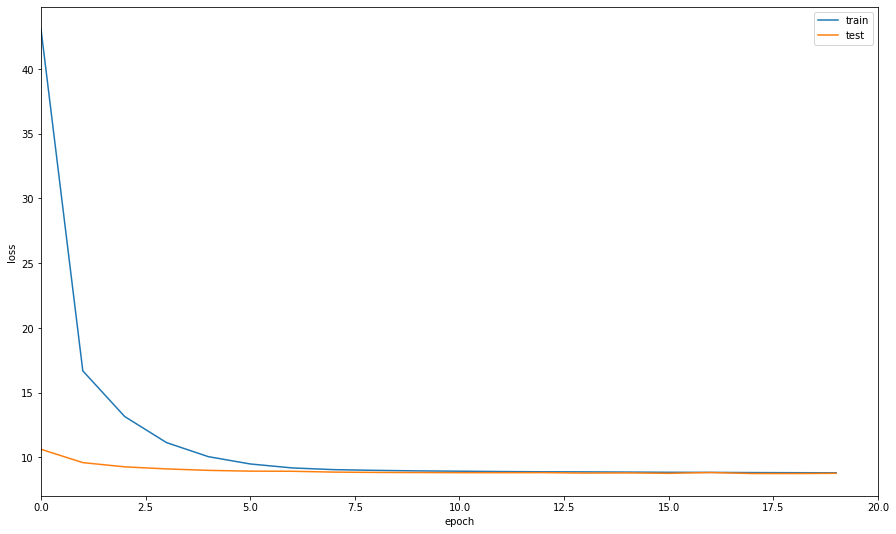

Train loss: 8.7974653840065
Val loss: 8.758239604532719


In [36]:
train_losses, val_losses = train(model, criterion, optimizer, train_loader, test_loader, 20)

Здесь результат отличается от того, что на картинке ниже (но тоже <8.77). Я хотел убедиться, что после первого запуска порог тоже преодолевается -- убедился!

А это как раз ячейка, которая на картинке ниже.

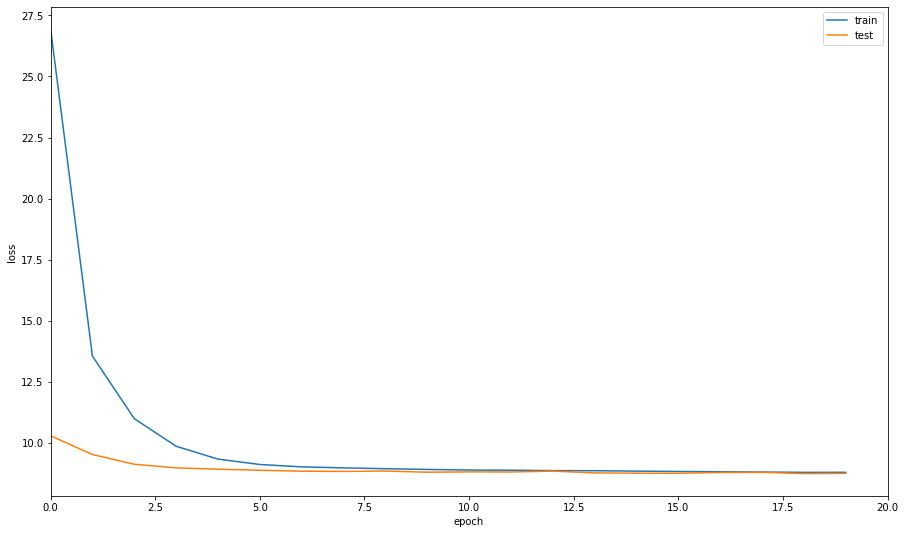

Train loss: 8.791840955615044
Val loss: 8.748405143618584


In [175]:
train_losses, val_losses = train(model, criterion, optimizer, train_loader, test_loader, 20)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

В качестве бейзлайна я взял самую простую архитектуру, состоящую из 3 полносвязых слоев:  
Linear(90, 100) -> Linear(100, 50) -> Linear(50,1) с нелинейностями LeakyReLU между ними.  
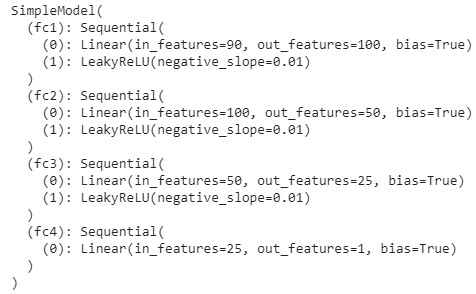  
*То, что я не менял:*  
*В качестве оптимайзера я все время использовал AdamW. `learning rate` я тоже не изменял, по итогу оказалось, что это было не самым плохим решением.*  
*Размер батча всегда равен 128.*  
*Количество эпох равно 20.*  
Конечно, полученная метрика (**RMSE**) получилась большой и не приближалась даже к порогу на оценку 4.  
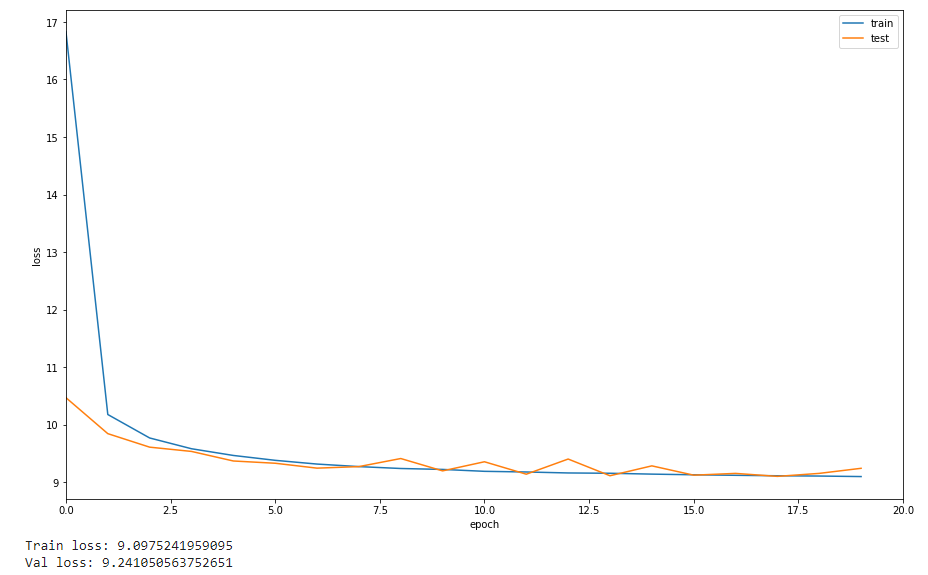  


Далее я решил добавить слои `BatchNorm`, так как они нормализуют данные перед подачей в полносвязные слои.  
Новая архитектура:  
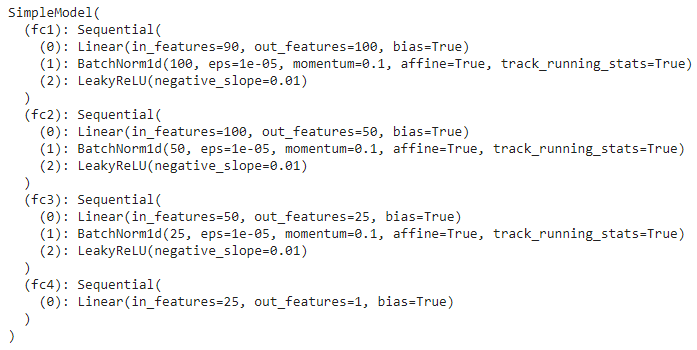  

Лосс заметно снизился! Теперь мы пробиваем порог на оценку 8!  
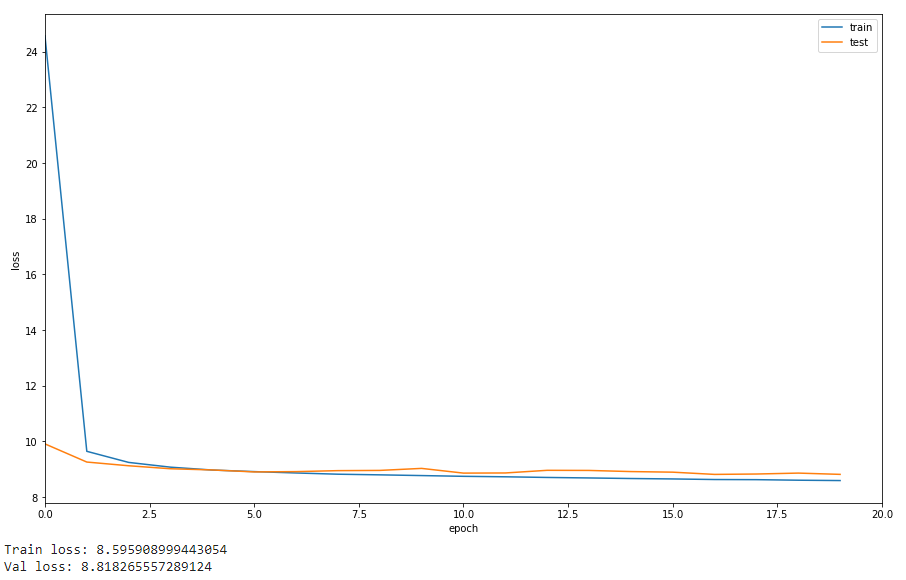

А еще колебания на трейне уменьшились, это говорит о том, что удалось снизить переобучение!

Посмотрим, к чему приведет добавление `dropout'ов`:)  
Новая архитектура:  


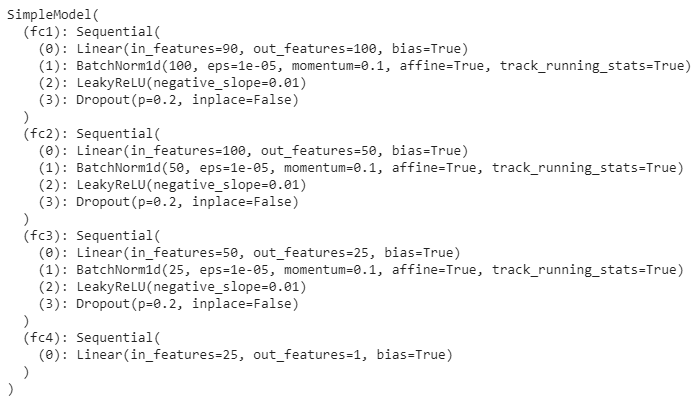

Получили неплохой результат. График loss'а на тесте стал очень стабильным. При этом, в качестве практически не потеряли.
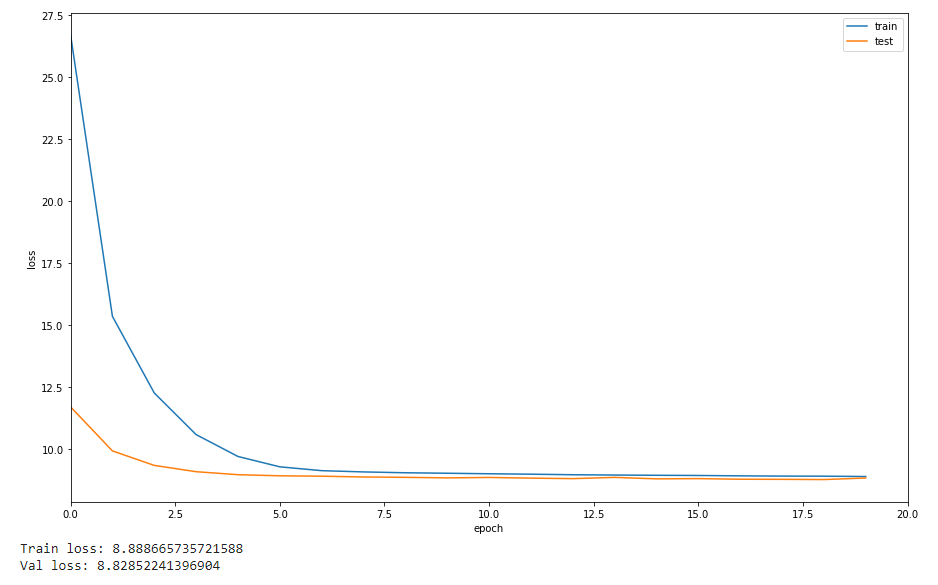

Попробуем убрать один `dropout`. Так как 2 dropout слоя еще останутся, то мы сможем сохранить стабильность, но исключение одного дропаута может понизить лосс.

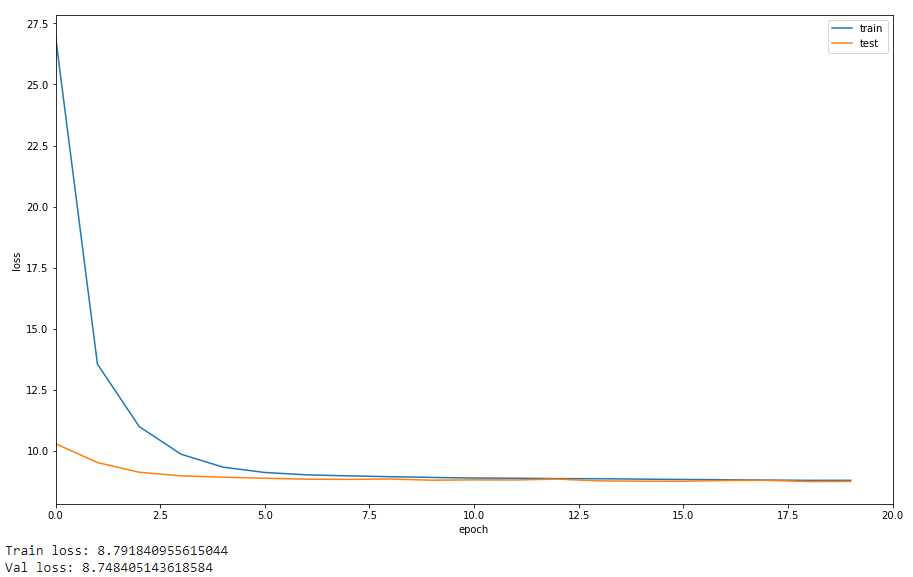

Действительно, помогло! Успешно получилось добиться лосса, который меньше 8.77!